# Server-side Feature Inference Attacks against Split Learning: CIFAR datasets

## Import packages and dataset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import sl_with_attack
from sl_with_attack import *
from datasets import *

xpub, xpriv = load_cifar10()

## Setting up hyperparameters and util functions

In [9]:
batch_size = 64
id_setup = 4
hparams = {
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'lr_f' :  0.001,
    'lr_encoder': 0.0001,
    # 'lr_tilde' : 0.0001,
    'lr_decoder': 0.00001,
    'lr_discriminator': 0.0001,
    'lr_classify': 0.00001,
}

iterations = 10000
log_frequency = 200

def plot_log(ax, x, y, label=None, color='blue'):
    ax.plot(x, y, color=color)
    ax.grid()
    if label is not None:
        ax.set(title=label)

## Model architectures

In [10]:
def ResBlock(inputs, dim, ks=3, bn=False, activation='relu', reduce=1):
    x = inputs
    
    stride = reduce
    
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(dim, ks, stride, padding='same')(x)
    
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(dim, ks, padding='same')(x)
    
    if reduce > 1:
        inputs = tf.keras.layers.Conv2D(dim, ks, stride, padding='same')(inputs)
    
    return inputs + x

def f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2D(64, 3, 1, padding='same')(xin)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = ResBlock(x, 64)
    x = ResBlock(x, 128, reduce=2)
    x = ResBlock(x, 128)
    x = ResBlock(x, 256, reduce=2)
    return tf.keras.Model(xin, x)

def g(input_shape, class_num):
    xin = tf.keras.layers.Input(input_shape)
    x = xin
    x = ResBlock(xin, 256)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if class_num == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = class_num

    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(xin, x)

def encoder(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    x = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=act)(xin)
    x = tf.keras.layers.Conv2D(128, 3, 2, padding='same', activation=act)(x)
    x = tf.keras.layers.Conv2D(256, 3, 2, padding='same', activation=act)(x)
    x = tf.keras.layers.Conv2D(256, 3, 1, padding='same')(x)
    return tf.keras.Model(xin, x)

def decoder(input_shape, channels=3):
    xin = tf.keras.layers.Input(input_shape)
    act = None
    x = tf.keras.layers.Conv2DTranspose(256, 3, 2, padding='same', activation=act)(xin)
    x = tf.keras.layers.Conv2DTranspose(128, 3, 2, padding='same', activation=act)(x)
    x = tf.keras.layers.Conv2DTranspose(channels, 3, 2, padding='same', activation="tanh")(x)
    return tf.keras.Model(xin, x)

def discriminator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2D(256, 3, 1, padding='same')(xin)
    bn = False
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = tf.keras.layers.Conv2D(256, 3, 2, padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(xin, x)

In [11]:
models = (f, g, encoder, decoder, discriminator)

## No attack: original task performance reference

In [5]:
no_attack = sl_with_attack(models, xpriv, xpub, id_setup-1, batch_size, hparams, 10, server_attack=None)
log_no_attack = no_attack(iterations, verbose=True, progress_bar=False, log_frequency=log_frequency)

RUNNING...


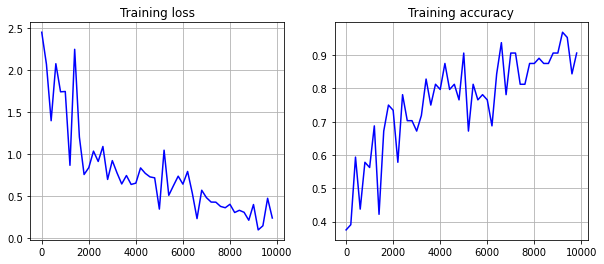

In [14]:
n = 2
fix, ax = plt.subplots(1, n, figsize=(n*5, 4))
x = np.arange(0, len(log_no_attack)) * log_frequency

plot_log(ax[0], x, log_no_attack[:, 0], label='Training loss')
plot_log(ax[1], x, log_no_attack[:, 1],  label='Training accuracy')

## Active attack: reconstruction performance reference

In [12]:
active = sl_with_attack(models, xpriv, xpub, id_setup-1, batch_size, hparams, 10, server_attack="active")
log_active = active(iterations, verbose=True, progress_bar=False, log_frequency=log_frequency)

RUNNING...
[log--01%-0000199] reconstruction validation: 0.2686
Original task: train loss: 2.3847 train accuracy: 0.3508
[log--03%-0000399] reconstruction validation: 0.2679
Original task: train loss: 1.9906 train accuracy: 0.4212
[log--05%-0000599] reconstruction validation: 0.2655
Original task: train loss: 1.8967 train accuracy: 0.4320
[log--07%-0000799] reconstruction validation: 0.2630
Original task: train loss: 1.8754 train accuracy: 0.4338
[log--09%-0000999] reconstruction validation: 0.2658
Original task: train loss: 1.7683 train accuracy: 0.4511
[log--11%-0001199] reconstruction validation: 0.1927
Original task: train loss: 1.8302 train accuracy: 0.4320
[log--13%-0001399] reconstruction validation: 0.1477
Original task: train loss: 1.8784 train accuracy: 0.4156
[log--15%-0001599] reconstruction validation: 0.1185
Original task: train loss: 1.8765 train accuracy: 0.4141
[log--17%-0001799] reconstruction validation: 0.1053
Original task: train loss: 1.8233 train accuracy: 0.4224

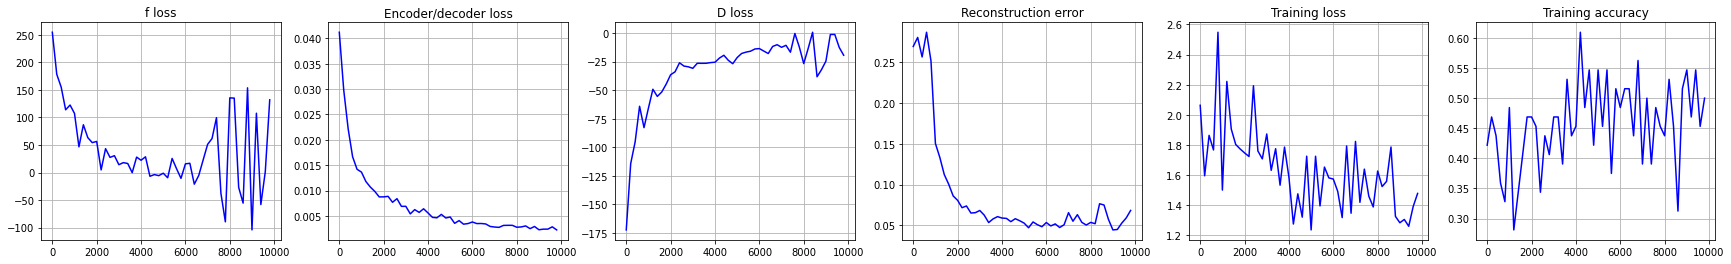

In [13]:
n = 6
fix, ax = plt.subplots(1, n, figsize=(n*5, 4))
x = np.arange(0, len(log_active)) * log_frequency

plot_log(ax[0], x, log_active[:, 0],  label='f loss')
plot_log(ax[1], x, log_active[:, 1],  label='Encoder/decoder loss')
plot_log(ax[2], x, log_active[:, 2],  label='D loss')
plot_log(ax[3], x, log_active[:, 3],  label='Reconstruction error')
plot_log(ax[4], x, log_active[:, 4], label='Training loss')
# plot_log(ax[4], x, log_no_attack[:,0], color='red')
plot_log(ax[5], x, log_active[:, 5],  label='Training accuracy')
# plot_log(ax[5], x, log_no_attack[:,1], color='red')

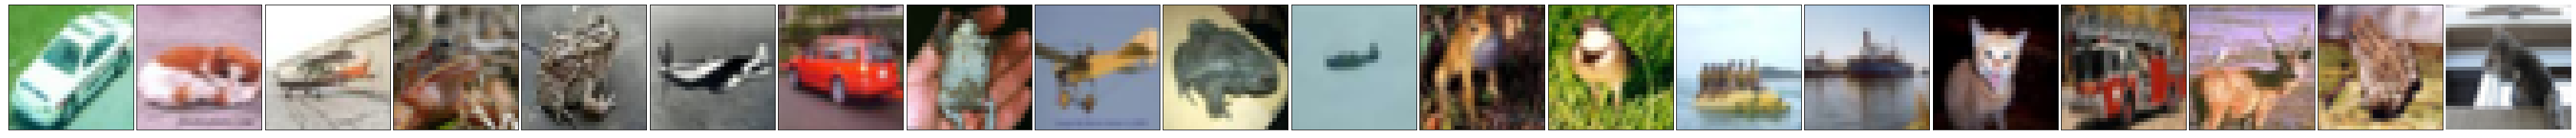

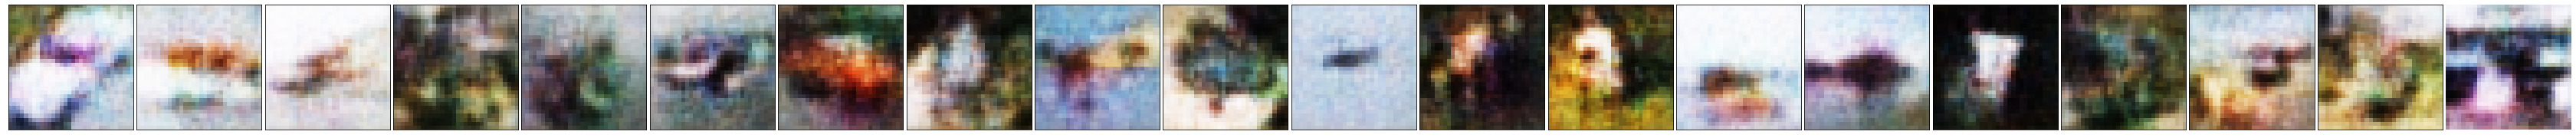

In [14]:
n = 20
X = getImagesDS(xpriv, n)
X_recovered, control = active.attack(X)

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno');  
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
        
    return fig

fig = plot(X)
fig = plot(X_recovered)

## Passive Attack

In [12]:
passive = sl_with_attack(models, xpriv, xpub, id_setup-1, batch_size, hparams, 10, server_attack="passive")
log_passive = passive(iterations, verbose=True, progress_bar=False, log_frequency=log_frequency)

RUNNING...
[log--01%-0000199] reconstruction validation: 0.2637
Original task: train loss: 2.8014 train accuracy: 0.2236
[log--03%-0000399] reconstruction validation: 0.2510
Original task: train loss: 2.3182 train accuracy: 0.3135
[log--05%-0000599] reconstruction validation: 0.2185
Original task: train loss: 2.1047 train accuracy: 0.3555
[log--07%-0000799] reconstruction validation: 0.1910
Original task: train loss: 1.9507 train accuracy: 0.3992
[log--09%-0000999] reconstruction validation: 0.1661
Original task: train loss: 1.8411 train accuracy: 0.4245
[log--11%-0001199] reconstruction validation: 0.1402
Original task: train loss: 1.7799 train accuracy: 0.4402
[log--13%-0001399] reconstruction validation: 0.1336
Original task: train loss: 1.6843 train accuracy: 0.4668
[log--15%-0001599] reconstruction validation: 0.1273
Original task: train loss: 1.6169 train accuracy: 0.4832
[log--17%-0001799] reconstruction validation: 0.1254
Original task: train loss: 1.5423 train accuracy: 0.4966

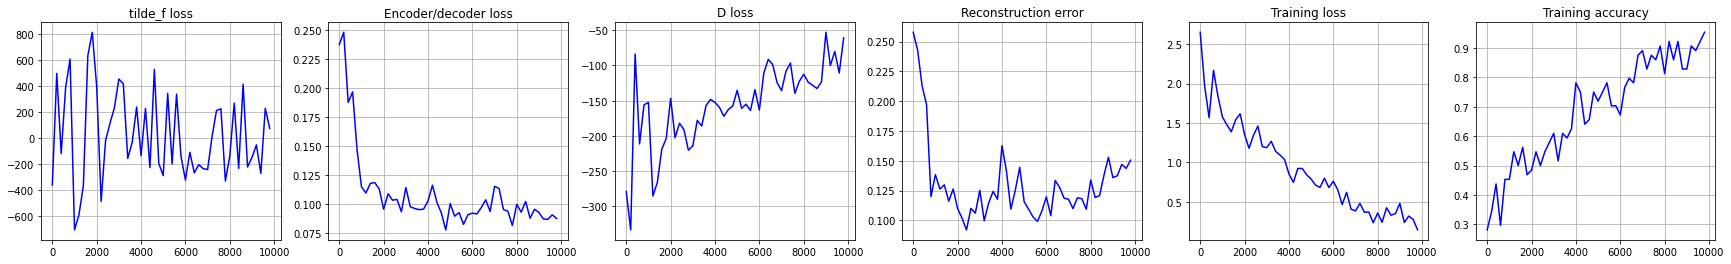

In [13]:
n = 6
fix, ax = plt.subplots(1, n, figsize=(n*5, 4))
x = np.arange(0, len(log_passive)) * log_frequency

plot_log(ax[0], x, log_passive[:, 0],  label='tilde_f loss')
plot_log(ax[1], x, log_passive[:, 1],  label='Encoder/decoder loss')
plot_log(ax[2], x, log_passive[:, 2],  label='D loss')
plot_log(ax[3], x, log_passive[:, 3],  label='Reconstruction error')
plot_log(ax[4], x, log_passive[:, 4], label='Training loss')
# plot_log(ax[4], x, log_no_attack[:,0], color='red')
plot_log(ax[5], x, log_passive[:, 5],  label='Training accuracy')
# plot_log(ax[5], x, log_no_attack[:,1], color='red')

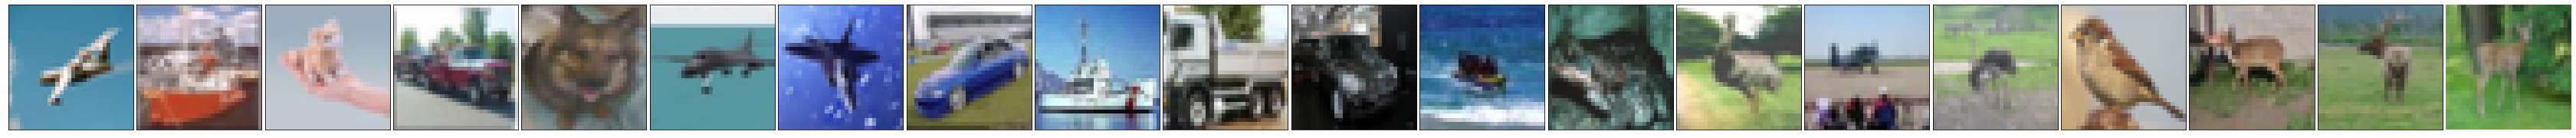

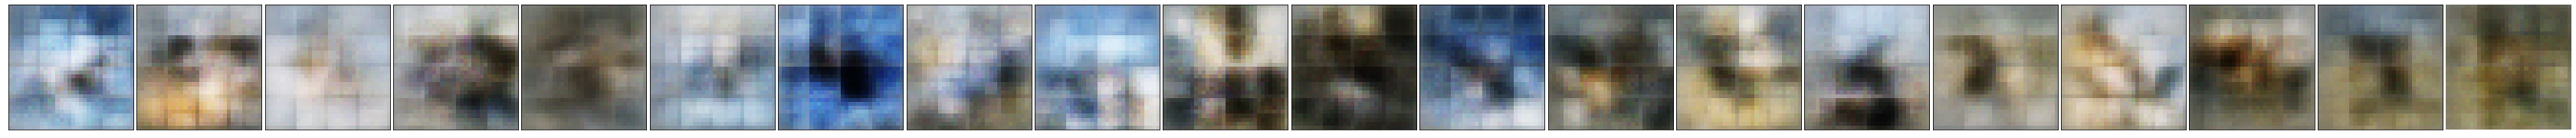

In [14]:
n = 20
X = getImagesDS(xpriv, n)
X_recovered, control = passive.attack(X)

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno')
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
        
    return fig

fig = plot(X)
fig = plot(X_recovered)

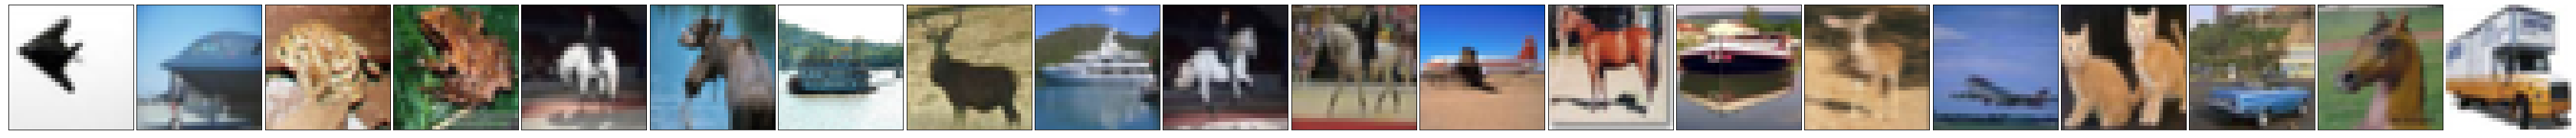

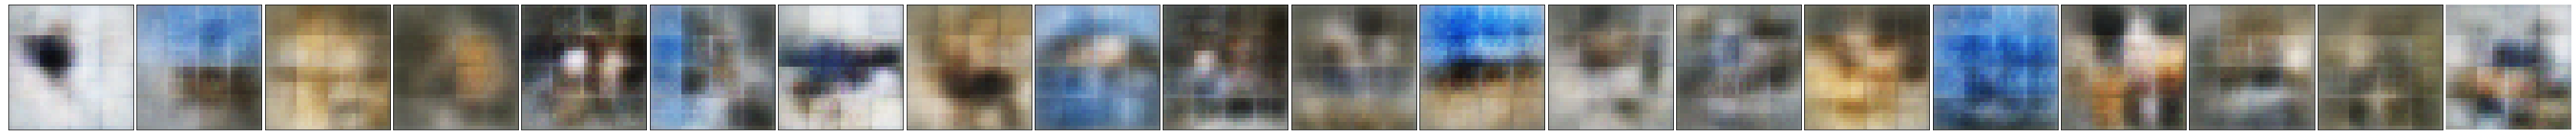

In [15]:
# server decoder decodes public dataset

pub = getImagesDS(xpub, n)
recovered = passive.decoder(passive.tilde_f(pub))

fig = plot(pub)
fig = plot(recovered)

## Save the models and outputs

In [29]:
no_attack.f.save('models/no_attack/f')
no_attack.g.save('models/no_attack/g')
active.f.save('models/active/f')
active.g.save('models/active/g')
active.decoder.save('models/active/decoder')
passive.f.save('models/passive/f')
passive.g.save('models/passive/g')
passive.decoder.save('models/passive/decoder')

INFO:tensorflow:Assets written to: models/no_attack/f\assets
INFO:tensorflow:Assets written to: models/no_attack/g\assets
INFO:tensorflow:Assets written to: models/active/f\assets
INFO:tensorflow:Assets written to: models/active/g\assets
INFO:tensorflow:Assets written to: models/active/decoder\assets
INFO:tensorflow:Assets written to: models/passive/f\assets
INFO:tensorflow:Assets written to: models/passive/g\assets
INFO:tensorflow:Assets written to: models/passive/decoder\assets


In [20]:
np.savetxt('./log/attacks/log_no_attack.csv', log_no_attack, delimiter=',')
np.savetxt('./log/attacks/log_active.csv', log_active, delimiter=',')
np.savetxt('./log/attacks/log_passive.csv', log_passive, delimiter=',')

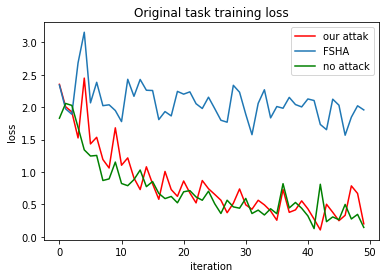

In [27]:
# plot the training loss:
plt.title("Original task training loss")
plt.ylabel('loss')
plt.xlabel('iteration')
plt.plot(log_passive[:,4], color='red')
plt.plot(log_active[:,4])
plt.plot(log_no_attack[:,0], color='green')
plt.legend(['our attak', 'FSHA', 'no attack'], loc='upper right')
plt.show()

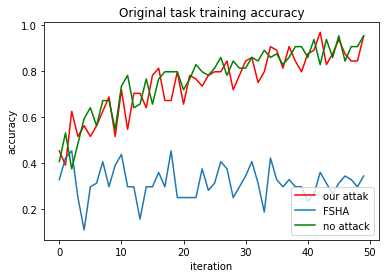

In [28]:
# plot the training accuracy:
plt.title("Original task training accuracy")
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.plot(log_passive[:,5], color='red')
plt.plot(log_active[:,5])
plt.plot(log_no_attack[:,1], color='green')
plt.legend(['our attak', 'FSHA', 'no attack'], loc='lower right')
plt.show()

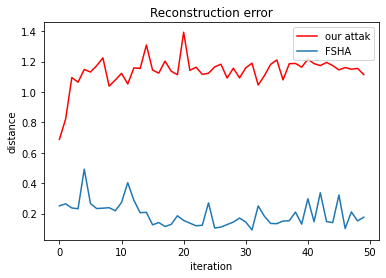

In [29]:
# plot the reconstruction error:
plt.title("Reconstruction error")
plt.ylabel('distance')
plt.xlabel('iteration')
plt.plot(log_passive[:,3], color='red')
plt.plot(log_active[:,3])
plt.legend(['our attak', 'FSHA'], loc='upper right')
plt.show()